<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/computationalImaging/blob/master/waves/holography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Holography
## David Brady
## University of Arizona
## September 2021

This notebook considers holographic imaging. We specifically model Leith-Upatneiks holograms, quasi-random reference coding, Gabor holograms and neural despeckling of gabor holograms. 

## libraries

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage
import os
from matplotlib import animation, rc
from skimage import io
from skimage import transform
from skimage import filters
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
from google.colab import files
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import cv2
from keras.datasets import mnist



## Angular Spectrum Propagation

In [2]:
def g(f,d,lam):
#
# calculate the diffracted field for the 2d image f propagated a distance d with wavelength relative to the pixel pitch lam
# d is in units of wavelengths, lam is the ratio of the wavelength to the sampling period. We assume lam<< 1
#
  zPad=np.int(np.abs(d*lam)/4)
  inF=np.zeros(np.add(f.shape,[zPad,zPad])).astype('complex128')
  inF[np.int(inF.shape[0]/2-f.shape[0]/2):np.int(inF.shape[0]/2+f.shape[0]/2),np.int(inF.shape[0]/2-f.shape[0]/2):np.int(inF.shape[0]/2+f.shape[0]/2)]=f
  urange=np.linspace(-lam/2,lam/2,inF.shape[0])
  u,v = np.meshgrid(urange,urange)
  g=np.fft.ifft2(np.fft.fft2(inF)*np.fft.fftshift(np.exp(1j *2* np.pi *d*np.sqrt( 1 - u**2 - v**2))))
  return g

#### training and validation images

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0

11501568/11490434 [==============================] - 0s 0us/step


## Leith-Upatneiks holography

here we simulate propagation of a signal a length $d$ and then interference of the diffracted field with a reference signal $R e^{i2\pi \sin \theta \frac{x}{\lambda}}$.

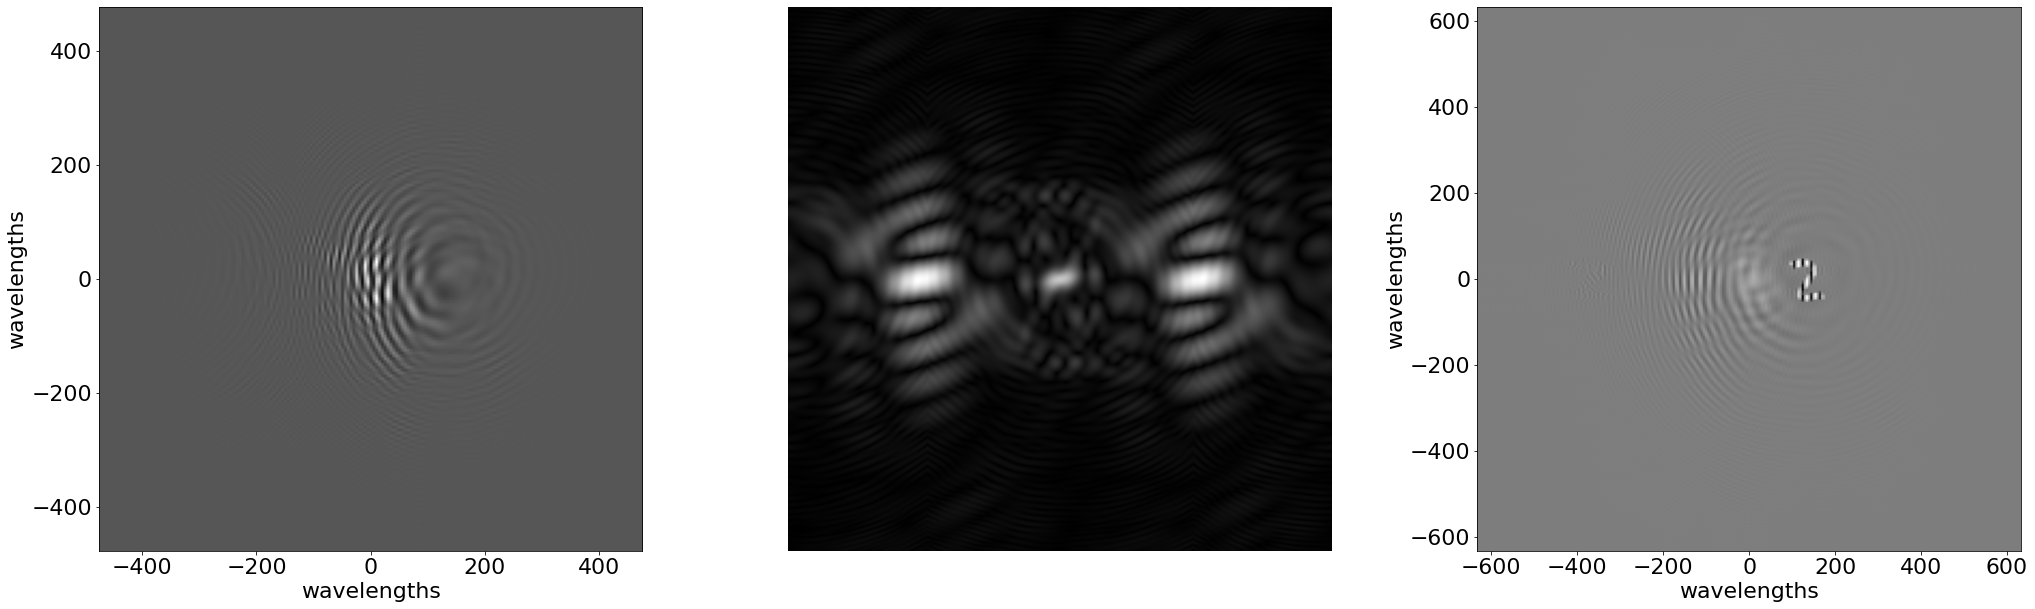

In [4]:
# diffracted field
plt.rcParams['figure.figsize'] = [35, 10]
plt.rcParams.update({'font.size': 22})
r=1
N=512
theta=np.pi/25
lam=.1 # ratio of wavelength to the sampling period
d=10000 # in units of wavelegnths
f=np.zeros([N,N])
# insert the mnist image in the center of the field
f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=x_test[1036,:,:]
q=g(f,d,lam)
xrange=q.shape[0]/(lam*2)
xR=np.linspace(-xrange,xrange,q.shape[0])
xx, yy= np.meshgrid(xR,xR)
holo=np.abs(q +r*np.exp(2*np.pi*1j*xx*np.sin(theta)))**2
plt.subplot(1,3,1)
holV=(holo-r**2)
ss=holV.shape[0]
plt.imshow(holV[np.int(3*ss/8):np.int(5*ss/8),np.int(3*ss/8):np.int(5*ss/8)],extent=[-xrange/8,xrange/8,-xrange/8,xrange/8 ],cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.subplot(1,3,2)
plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(holo-r**2))),cmap='gray', aspect='equal')
plt.axis('off')
plt.subplot(1,3,3)
recon=np.abs(g(holo,-d,lam))
xrange=recon.shape[0]/(lam*2)
ss=recon.shape[0]
plt.imshow(recon[np.int(3*ss/8):np.int(5*ss/8),np.int(3*ss/8):np.int(5*ss/8)],extent=[-xrange/8,xrange/8,-xrange/8,xrange/8],cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.savefig('leithHologram.pdf')
#files.download('leithHologram.pdf')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

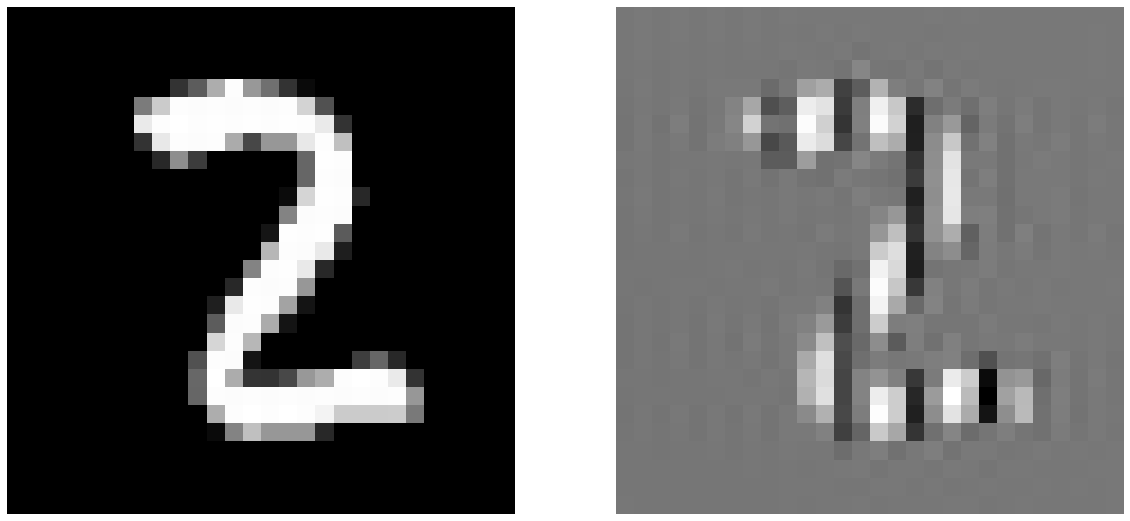

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.subplot(1,2,1)
plt.imshow(x_test[1036,:,:],cmap='gray', aspect='equal')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(np.abs(g(holo,-d,lam)[542:570,620:648]),cmap='gray', aspect='equal')
plt.axis('off')
plt.savefig('leithHologramDetail.pdf')
files.download('leithHologramDetail.pdf')


## Random reference signal

Here we consider adding a random reference signal to the recorded beam. We then modulate the recorded hologram with the same random code and inverse propagate to reconstruct the image

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

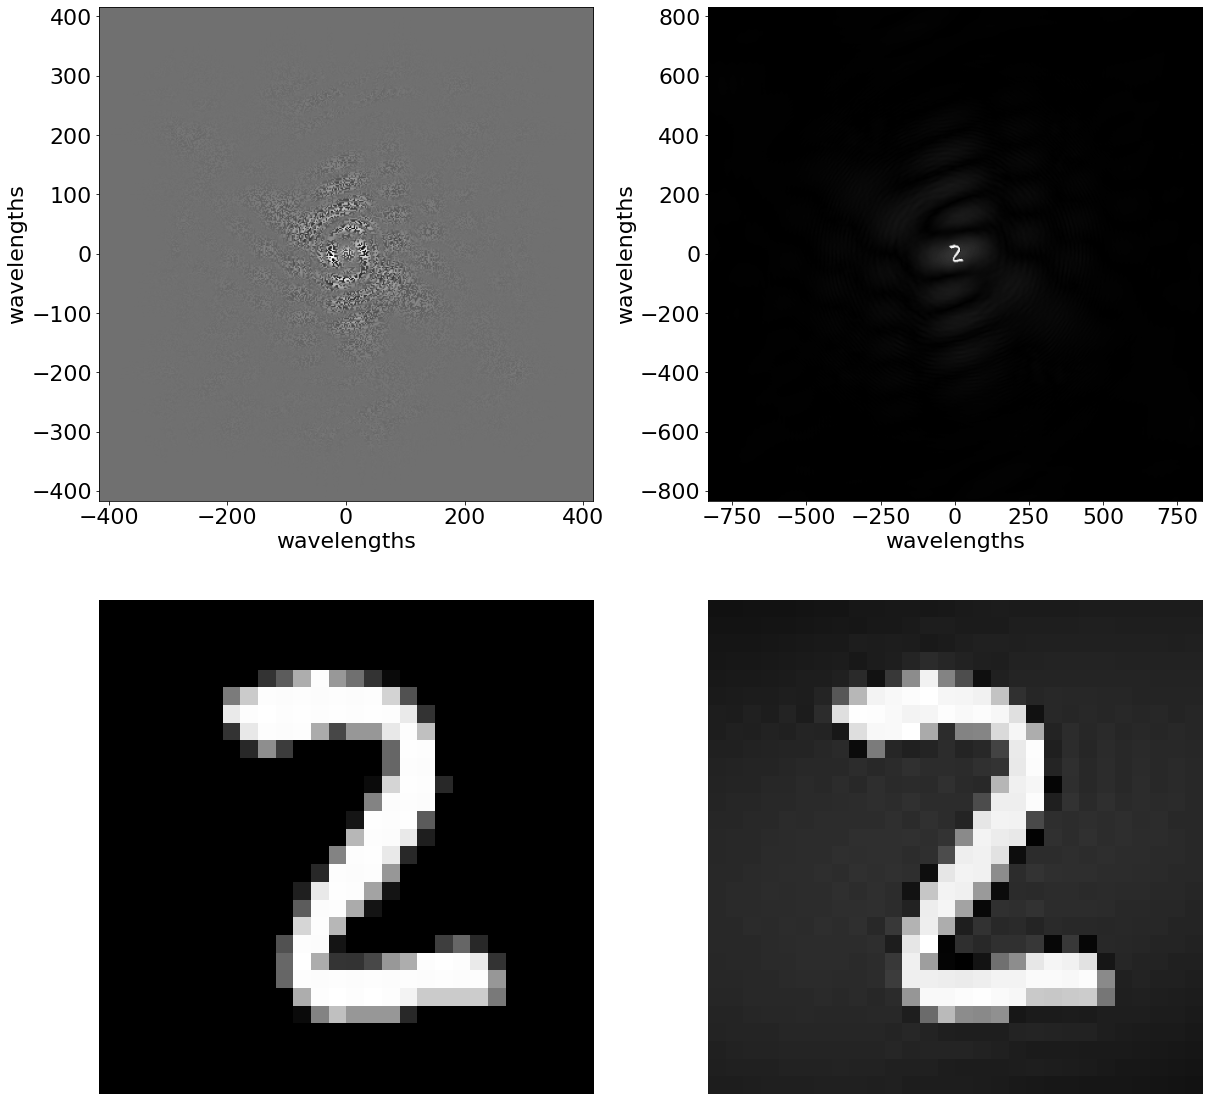

In [ ]:
# diffracted field
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams.update({'font.size': 22})
r=1
N=512
theta=np.pi/50
lam=.3 # ratio of wavelength to the sampling period
d=1000 # in units of wavelegnths
f=np.zeros([N,N])
# insert the mnist image in the center of the field
f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=x_test[1036,:,:]
q=g(f,d,lam)
xrange=d/(lam*2)
xR=np.linspace(-xrange,xrange,q.shape[0])
reference=np.exp(np.pi*1j*np.random.randint(2,size=q.shape))
holo=np.abs(q +reference)**2
plt.subplot(2,2,1)
hS=holo.shape[0]/4
plt.imshow(holo[np.int(hS):np.int(3*hS),np.int(hS):np.int(3*hS)],extent=[-xrange/4,xrange/4,-xrange/4,xrange/4], cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.subplot(2,2,2)
pip=g(reference*(holo-1),-d,lam)
xrange=d/lam
hS=pip.shape[0]/4
plt.imshow(np.abs(pip)[np.int(hS):np.int(3*hS),np.int(hS):np.int(3*hS)],extent=[-xrange/4,xrange/4,-xrange/4,xrange/4],cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.subplot(2,2,3)
plt.imshow(x_test[1036,:,:],cmap='gray', aspect='equal')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(np.abs(pip[542:570,542:570]),cmap='gray', aspect='equal')
plt.axis('off')
plt.savefig('randomHologram.pdf')
files.download('randomHologram.pdf')

## Gabor Holography

Predating Leith and Upatneiks, Gabor proposed inline holography. Typically with weak scattering, the unscattered signal acts as a reference for itself. Gabor holography is off axis holography with a zero degree off set. 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

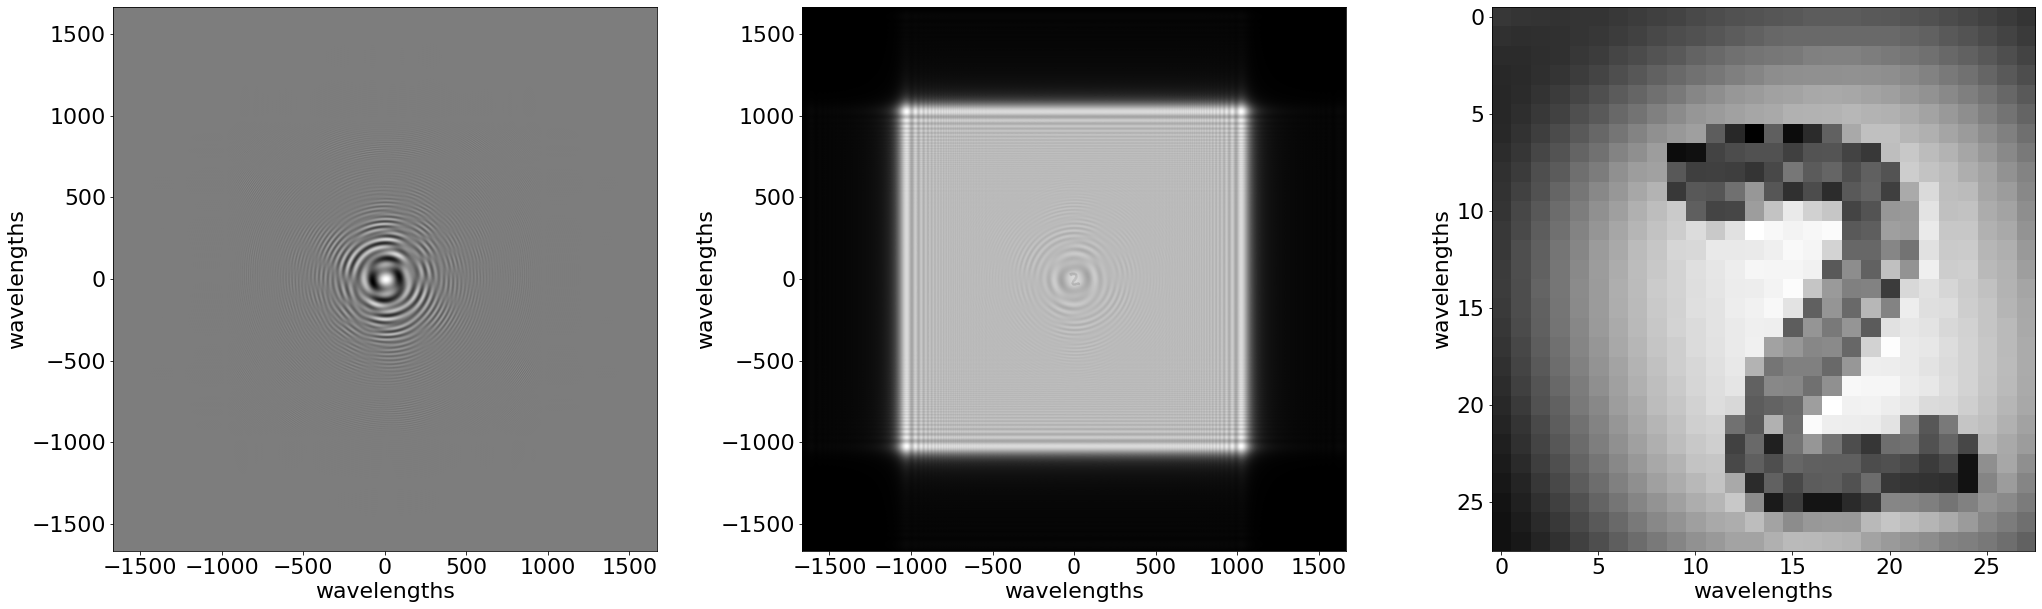

In [ ]:
# diffracted field
plt.rcParams['figure.figsize'] = [35, 10]
plt.rcParams.update({'font.size': 22})
r=1
N=256
theta=0
lam=.3 # ratio of wavelength to the sampling period
d=1000 # in units of wavelegnths
f=np.zeros([N,N])
# insert the mnist image in the center of the field
f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=x_test[1036,:,:]
q=g(f,d,lam)
xrange=d/(lam*2)
xR=np.linspace(-xrange,xrange,q.shape[0])
xx, yy= np.meshgrid(xR,xR)
holo=np.abs(q +r*np.exp(2*np.pi*1j*xx*np.sin(theta)))**2
plt.subplot(1,3,1)
plt.imshow(holo-r**2,extent=[-xrange,xrange,-xrange,xrange], cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.subplot(1,3,2)
plt.imshow(np.abs(g(holo,-d,lam)),extent=[-xrange,xrange,-xrange,xrange],cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.subplot(1,3,3)
plt.imshow(np.abs(g(holo,-d,lam)[412:440,412:440]),cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.savefig('gaborHologram.pdf')
files.download('gaborHologram.pdf')

### treating the image value as  phase

here we consider the meaning of phase in the object field. 

In the first instance we consider a surface relief hologram. Each object pixel has intensity value 1, but the phase $\phi$. The signal value is $e^[i\phi}$. In the second example, each object pixel has uniformly distributed random phase, which causes the reconstructed image to show speckle. 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

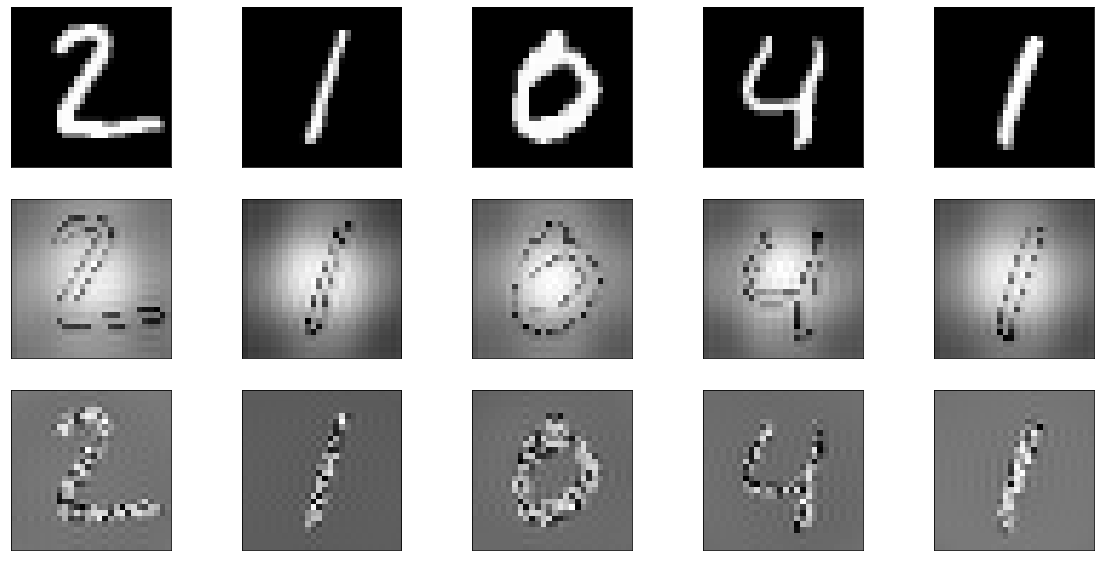

In [ ]:
# diffracted field
plt.figure(figsize=(20, 10))
r=1
N=150
lam=.3 # ratio of wavelength to the sampling period
d=600 # in units of wavelegnths
f=np.zeros([N,N]).astype('complex128')
# insert the mnist image in the center of the field
n = 5

for i in range(1, n + 1):
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, n+i)
    f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=np.exp(2*np.pi*1j*x_test[i,:,:])
    q=g(f,d,lam)
    holo=np.abs(q +r)**2
    plt.imshow(np.abs(g(holo,-d,lam))[241:269,241:269])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, 2*n+i)
    f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=np.exp(2*np.pi*1j*np.random.random((28,28)))*x_test[i,:,:]
    q=g(f,d,lam)
    holo=np.abs(q +r)**2
    plt.imshow(np.abs(g(holo,-d,lam)[241:269,241:269]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('gaborPhaseSpeckleImage.pdf')
files.download('gaborPhaseSpeckleImage.pdf')


In [ ]:
g(holo,-d,lam).shape

(510, 510)

### Random phase objects

Diffuse scatterers add a random phase to the scattered field in each pixel, creating speckle effects in the reconstructed image.

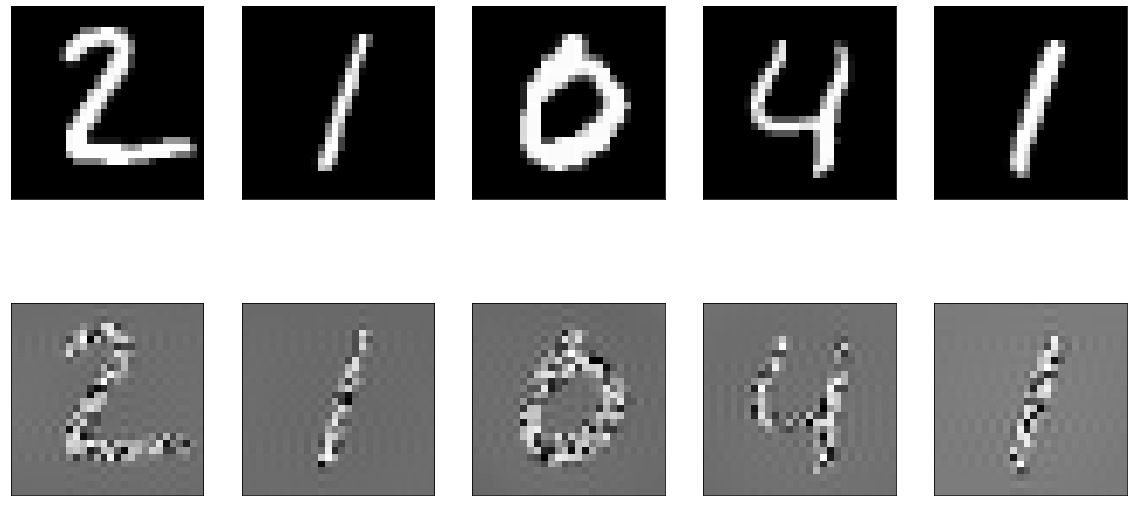

In [ ]:

plt.figure(figsize=(20, 10))
r=1
N=150
lam=.3 # ratio of wavelength to the sampling period
d=600 # in units of wavelegnths
f=np.zeros([N,N]).astype('complex128')
# insert the mnist image in the center of the field
n = 5

for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, n+i)
    f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=np.exp(2*np.pi*1j*np.random.random((28,28)))*x_test[i,:,:]
    q=g(f,d,lam)
    holo=np.abs(q +r)**2
    plt.imshow(np.abs(g(holo,-d,lam)[241:269,241:269]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
#plt.savefig('muraCodedApertureNeuralDenoise.pdf')
#files.download('muraCodedApertureNeuralDenoise.pdf')



## Neural processing of Gabor holograms

Many system geometries and strategies for neural reconstruction of holographic data may be considered. Here as a simple example we illustrate reconstruction of Gabor data.

The neural system is trained to remove both the background terms from the Gabor reconstruction and speckle effects. 

In [ ]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# load the mnist dataset of characters
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0
#
# holographic recordin parameters
r=1
N=150
lam=.3 # ratio of wavelength to the sampling period
d=600 # in units of wavelegnths
g_test=np.zeros((len(x_test),28,28,2))
g_train=np.zeros((len(x_train),28,28,2))


# generation of test inputs
for pop in range(np.shape(x_test)[0]):
  f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=np.exp(2*np.pi*1j*np.random.random((28,28)))*x_test[pop,:,:]
  q=g(f,d,lam)
  holo=np.abs(q +r)**2
  iq=g(holo,-d,lam)[241:269,241:269]
  iq=iq/np.max(np.abs(iq))
  g_test[pop,:,:,0]=(1+np.real(iq))/2
  g_test[pop,:,:,1]=(1+np.imag(iq))/2
# generation of training inputs
for pop in range(np.shape(x_train)[0]):
  f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=np.exp(2*np.pi*1j*np.random.random((28,28)))*x_train[pop,:,:]
  q=g(f,d,lam)
  holo=np.abs(q +r)**2
  iq=g(holo,-d,lam)[241:269,241:269]
  iq=iq/np.max(np.abs(iq))
  g_train[pop,:,:,0]=(1+np.real(iq))/2
  g_train[pop,:,:,1]=(1+np.imag(iq))/2
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))


In [ ]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [ ]:
np.savez('trainingArrays',g_test,g_train)
files.download('trainingArrays.npz')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cp trainingArrays.npz drive/MyDrive/Research/

In [ ]:
pip =np.load('drive/MyDrive/Research/trainingArrays.npz')

In [ ]:
g_test=pip['arr_0']
g_train=pip['arr_1']

In [ ]:
g_test.shape

(10000, 28, 28, 2)

### Estimation Model

In [ ]:

inputs=keras.Input(shape=(28, 28, 2))

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(inputs)
x = layers.Conv2D(64, (4, 4), strides=2, activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), strides=1, activation="relu", padding="same")(x)


# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)

gaborEstimator = keras.Model(inputs, x)
gaborEstimator.compile(optimizer='adam', loss='mean_squared_error')
gaborEstimator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 2)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        1632      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        32832     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464 

### training

In [ ]:

gaborEstimator.fit(
    x=g_train,
    y=x_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_test),
)

Epoch 1/10
469/469 [==============================] - 5s 10ms/step - loss: 0.0071 - val_loss: 0.0057
Epoch 2/10
469/469 [==============================] - 5s 10ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 3/10
469/469 [==============================] - 5s 10ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 4/10
469/469 [==============================] - 5s 10ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 5/10
469/469 [==============================] - 5s 10ms/step - loss: 0.0049 - val_loss: 0.0492
Epoch 6/10
469/469 [==============================] - 5s 10ms/step - loss: 0.0133 - val_loss: 0.0070
Epoch 7/10
469/469 [==============================] - 5s 10ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 8/10
469/469 [==============================] - 5s 10ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 9/10
469/469 [==============================] - 5s 10ms/step - loss: 0.0054 - val_loss: 0.0047
Epoch 10/10
469/469 [==============================] - 5s 10ms/step - loss: 0.0092 - val_lo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

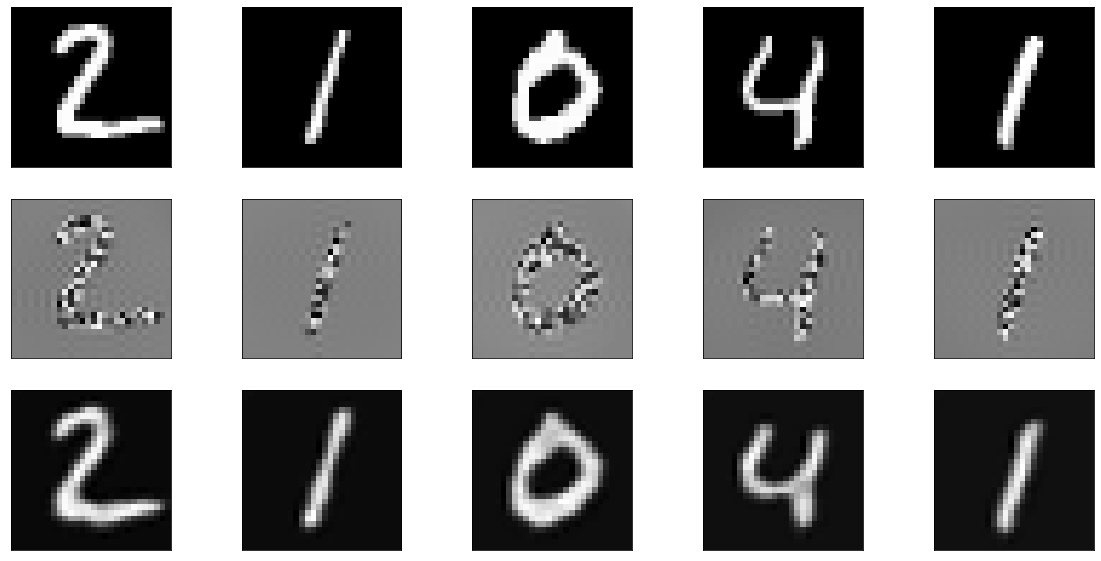

In [ ]:
n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, n+i)
    plt.imshow(g_test[i,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, 2*n+i)
    plt.imshow(gaborEstimator.predict(g_test[i:i+1,:,:,:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('neuralGaborDespeckle.pdf')
files.download('neuralGaborDespeckle.pdf')